# 📊 Yelpデータセット EDA（探索的データ分析）

このノートブックでは、Yelpレビューに関する構造・分布・統計・可視化を行い、
モデル構築や整合性学習の前提となるデータ理解を深めることを目的とします。


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# グラフの日本語対応やスタイル設定（任意）
sns.set(style="whitegrid")
%matplotlib inline

In [3]:
import json
import polars as pl

In [6]:
# Yelpレビューのデータパス
review_data_path = "../data/raw/yelp_academic_dataset_review.json"

# 全データをPolarsで効率的に読み込み
df = pl.read_ndjson(review_data_path)

# データ確認（先頭5行）
print(df.head(5))

shape: (5, 9)
┌──────────────┬──────────────┬─────────────┬───────┬───┬───────┬──────┬─────────────┬─────────────┐
│ review_id    ┆ user_id      ┆ business_id ┆ stars ┆ … ┆ funny ┆ cool ┆ text        ┆ date        │
│ ---          ┆ ---          ┆ ---         ┆ ---   ┆   ┆ ---   ┆ ---  ┆ ---         ┆ ---         │
│ str          ┆ str          ┆ str         ┆ f64   ┆   ┆ i64   ┆ i64  ┆ str         ┆ str         │
╞══════════════╪══════════════╪═════════════╪═══════╪═══╪═══════╪══════╪═════════════╪═════════════╡
│ KU_O5udG6zpx ┆ mh_-eMZ6K5RL ┆ XQfwVwDr-v0 ┆ 3.0   ┆ … ┆ 0     ┆ 0    ┆ If you      ┆ 2018-07-07  │
│ Og-VcAEodg   ┆ WhZyISBhwA   ┆ ZS3_CbbE5Xw ┆       ┆   ┆       ┆      ┆ decide to   ┆ 22:09:11    │
│              ┆              ┆             ┆       ┆   ┆       ┆      ┆ eat here,   ┆             │
│              ┆              ┆             ┆       ┆   ┆       ┆      ┆ jus…        ┆             │
│ BiTunyQ73aT9 ┆ OyoGAe7OKpv6 ┆ 7ATYjTIgM3j ┆ 5.0   ┆ … ┆ 0     ┆ 1    ┆ I've

In [25]:
# 評価値ごとの件数を集計
stars_count = (
    df.group_by("stars")
      .agg(pl.len().alias("review_count"))
      .sort("stars")
)

# 結果の確認
print(stars_count)


shape: (5, 2)
┌───────┬──────────────┐
│ stars ┆ review_count │
│ ---   ┆ ---          │
│ f64   ┆ u32          │
╞═══════╪══════════════╡
│ 1.0   ┆ 1069561      │
│ 2.0   ┆ 544240       │
│ 3.0   ┆ 691934       │
│ 4.0   ┆ 1452918      │
│ 5.0   ┆ 3231627      │
└───────┴──────────────┘


/var/folders/lz/4tkhtj69333b7wp6ksdrz57w0000gn/T/ipykernel_3559/3793991649.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stars_count["stars"], y=stars_count["review_count"], palette="viridis")


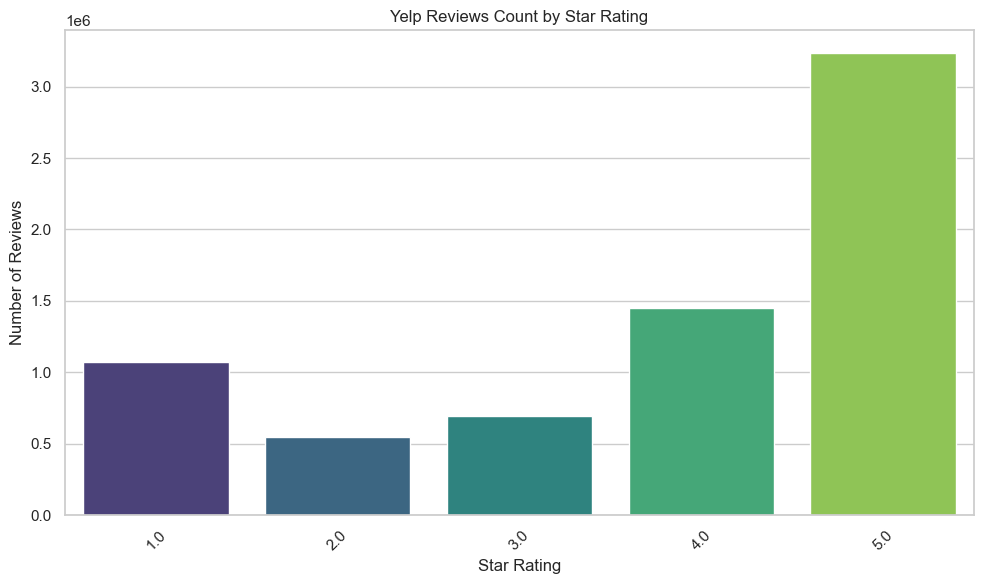

In [28]:
# 評価値ごとの件数を可視化
plt.figure(figsize=(10, 6))
sns.barplot(x=stars_count["stars"], y=stars_count["review_count"], palette="viridis")
plt.title("Yelp Reviews Count by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../data/processed/yelp_reviews_count_by_stars.png")
plt.show()



In [22]:
# ユーザごとのレビュー数を集計
user_review_counts = (
    df.group_by("user_id")
      .agg(pl.len().alias("review_count"))
)

# 総ユーザ数
total_users = user_review_counts.shape[0]

# 1件しか投稿していないユーザ数
one_review_users = user_review_counts.filter(pl.col("review_count") == 1).shape[0]

# 割合を算出
one_review_ratio = one_review_users / total_users

print(f"総ユーザ数: {total_users}")
print(f"1件だけのユーザ数: {one_review_users}")
print(f"1件ユーザの割合: {one_review_ratio:.2%}")


総ユーザ数: 1987929
1件だけのユーザ数: 1136008
1件ユーザの割合: 57.15%


In [24]:
# レビュー本文の長さ（文字数）を計算
df_with_length = df.with_columns(
    pl.col("text").str.len_chars().alias("text_length")  # もしくは pl.col("text").str.n_chars()
)

# レビュー長の統計量を計算
text_length_stats = df_with_length.select([
    pl.col("text_length").mean().alias("平均文字数"),
    pl.col("text_length").median().alias("中央値"),
    pl.col("text_length").std().alias("標準偏差"),
    pl.col("text_length").min().alias("最短"),
    pl.col("text_length").max().alias("最長"),
])

print(text_length_stats)


shape: (1, 5)
┌────────────┬────────┬────────────┬──────┬──────┐
│ 平均文字数 ┆ 中央値 ┆ 標準偏差   ┆ 最短 ┆ 最長 │
│ ---        ┆ ---    ┆ ---        ┆ ---  ┆ ---  │
│ f64        ┆ f64    ┆ f64        ┆ u32  ┆ u32  │
╞════════════╪════════╪════════════╪══════╪══════╡
│ 567.764436 ┆ 406.0  ┆ 527.257809 ┆ 1    ┆ 5000 │
└────────────┴────────┴────────────┴──────┴──────┘


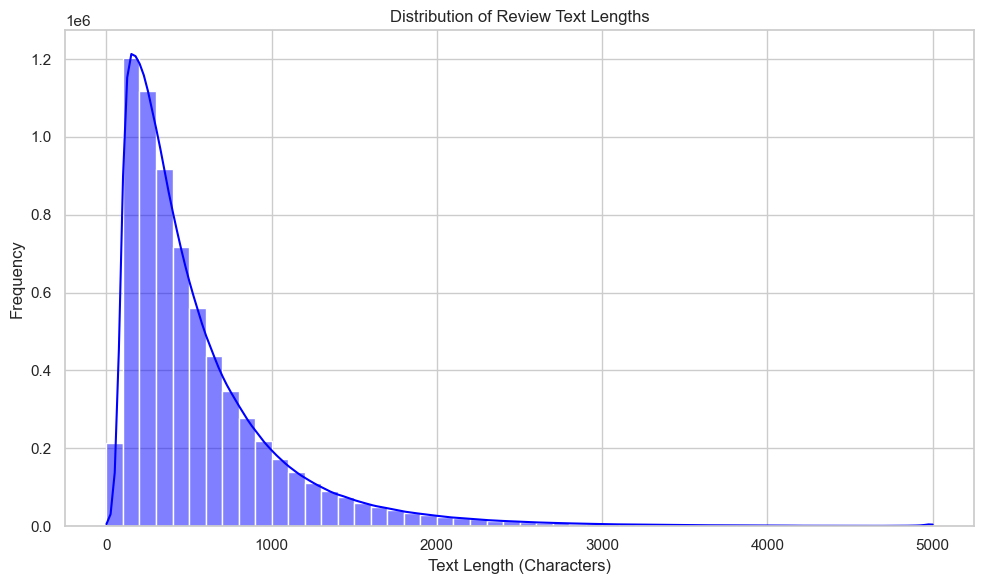

In [29]:
# 文字数の分布を可視化
plt.figure(figsize=(10, 6))
sns.histplot(df_with_length["text_length"], bins=50, kde=True, color="blue")
plt.title("Distribution of Review Text Lengths")
plt.xlabel("Text Length (Characters)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("../data/processed/yelp_review_text_length_distribution.png")
plt.show()


In [46]:
# 先頭5件すべての本文と文字数を完全に表示
for i, row in enumerate(df_with_length.select(["text", "text_length"]).iter_rows(), start=1):
    print(f"\n--- Review {i} ---")
    print(f"文字数: {row[1]}")
    print(f"本文:\n{row[0]}")



--- Review 1 ---
文字数: 513
本文:
If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. 

The food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.

--- Review 2 ---
文字数: 829
本文:
I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out.

For anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in advanced like many gyms make you do).

There is no way